In [1]:
from tensorflow import keras
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 가져오고 전처리
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

scaler = StandardScaler()
# 갑작스럽지만 fit_transform은 평균 표준편차를 구하고 그거에 따라 정규화 하는거고 transform은 앞에서 구한 평균 표준편차에 따라 정규화만 함
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
X_train.shape

(11610, 8)

In [2]:
# 신경망 구축 및 모델 학습
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='sgd')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]  # new샘플
print(mse_test)
print(y_test[:3])
model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 63us/sample - loss: 0.7402 - val_loss: 12.8364
Epoch 2/10
11610/11610 [==============================] - 0s 36us/sample - loss: 1.1668 - val_loss: 0.4557
Epoch 3/10
11610/11610 [==============================] - 1s 44us/sample - loss: 0.5449 - val_loss: 0.4033
Epoch 4/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4233 - val_loss: 0.3977
Epoch 5/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4051 - val_loss: 0.3964
Epoch 6/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4129 - val_loss: 0.3840
Epoch 7/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4001 - val_loss: 0.3881
Epoch 8/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4065 - val_loss: 0.3920
Epoch 9/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.3881 - val_

array([[1.2573755],
       [2.2307024],
       [2.1249328]], dtype=float32)

In [3]:
# 복잡한 모델: 일부 특성은 더 짧은 경로로 가게

input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B) # input_B에서 hidden1층으로 연결한다는 소리
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)  
concat = keras.layers.concatenate([input_A, hidden2])  # input_A랑 hidden2층이랑 연결
output = keras.layers.Dense(1)(concat)  # 결국 다 이 출력층으로 연결될 수 있게
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

In [4]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))  # optimizer은 경사하강법(학습률 설정)

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=10, validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
print(mse_test)
model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 64us/sample - loss: 2.3173 - val_loss: 1.1871
Epoch 2/10
11610/11610 [==============================] - 0s 43us/sample - loss: 0.9230 - val_loss: 0.8392
Epoch 3/10
11610/11610 [==============================] - 0s 42us/sample - loss: 0.7534 - val_loss: 0.7394
Epoch 4/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.6838 - val_loss: 0.6886
Epoch 5/10
11610/11610 [==============================] - 0s 42us/sample - loss: 0.6430 - val_loss: 0.6477
Epoch 6/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.6138 - val_loss: 0.6251
Epoch 7/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.5906 - val_loss: 0.6025
Epoch 8/10
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5714 - val_loss: 0.5822
Epoch 9/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5544 - val_l

array([[1.4693388],
       [1.8375902],
       [2.2054548]], dtype=float32)

In [5]:
# 위 코드를 서브클래싱 API로 만들어서 사용해보자

class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation) 
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        return main_output
    
model = WideAndDeepModel()

In [6]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), y_train, epochs=10, validation_data=((X_valid_A, X_valid_B), y_valid))
model.summary()

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 72us/sample - loss: 2.7905 - val_loss: 1.1421
Epoch 2/10
11610/11610 [==============================] - 0s 41us/sample - loss: 0.8606 - val_loss: 0.7784
Epoch 3/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.6941 - val_loss: 0.6766
Epoch 4/10
11610/11610 [==============================] - 0s 36us/sample - loss: 0.6306 - val_loss: 0.6196
Epoch 5/10
11610/11610 [==============================] - 1s 48us/sample - loss: 0.5894 - val_loss: 0.5826
Epoch 6/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.5589 - val_loss: 0.5545
Epoch 7/10
11610/11610 [==============================] - 1s 48us/sample - loss: 0.5364 - val_loss: 0.5363
Epoch 8/10
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5189 - val_loss: 0.5218
Epoch 9/10
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5048 - val_l

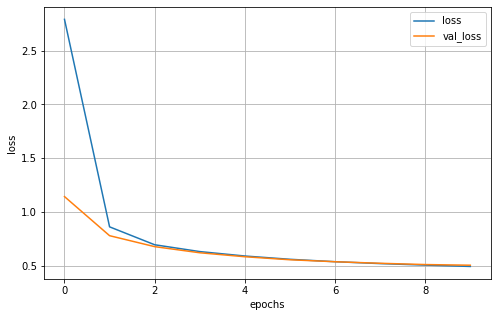

In [7]:
# 시각화
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))  
plt.grid(True) 
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [10]:
"""가장 좋은 하이퍼파라미터 조합 고르기"""

from scipy.stats import reciprocal  # 역수
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

def build_model(n_hidden=1, n_neurons=10, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=learning_rate))
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

params_distribs = {
    'n_hidden': [0, 1, 2],
    'n_neurons': np.arange(1, 10),
    'learning_rate': reciprocal(3e-4, 3e-2)
}

rnd_search_cv = RandomizedSearchCV(keras_reg, params_distribs, n_iter=3, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Train on 7740 samples, validate on 3870 samples
Epoch 1/5
7740/7740 [==============================] - 1s 68us/sample - loss: 4.6074 - val_loss: 14.7425
Epoch 2/5
7740/7740 [==============================] - 0s 42us/sample - loss: 3.4161 - val_loss: 13.8596
Epoch 3/5
7740/7740 [==============================] - 0s 34us/sample - loss: 2.5713 - val_loss: 13.2600
Epoch 4/5
7740/7740 [==============================] - 0s 35us/sample - loss: 1.9708 - val_loss: 12.8594
Epoch 5/5
3870/3870 [==============================] - 0s 18us/sample - loss: 3.0394
Train on 7740 samples, validate on 3870 samples
Epoch 1/5
7740/7740 [==============================] - 1s 66us/sample - loss: 5.1238 - val_loss: 6.9686
Epoch 2/5
7740/7740 [==============================] - 0s 41us/sample - loss: 3.7701 - val_loss: 4.7378
Epoch 3/5
7740/7740 [==============================] - 0s 41us/sample - loss: 2.8372 - val_loss: 3.3347
Epoch 4/5
7740/7740 [==============================] - 0s 42us/sample - loss: 2.1875 - 

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000016AD6AF2D88>, as the constructor either does not set or modifies parameter learning_rate